# In-Depth: Manifold Learning

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns

In [11]:
def make_hello(N=1000, rseed=42):
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png') 
    plt.close(fig)
    from matplotlib.image import imread 
    data = imread('hello.png')[::-1, :, 0].T 
    rng = np.random.RandomState(rseed) 
    X = rng.rand(4 * N, 2) 
    i, j = (X * data.shape).astype(int).T 
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1]) 
    return X[np.argsort(X[:, 0])]

(-0.1997925938161504,
 4.196668328611378,
 0.019424089027564297,
 1.00023375581081)

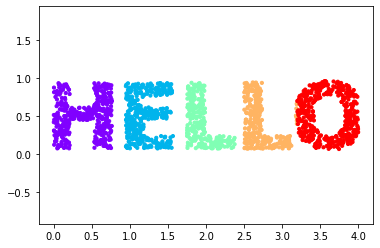

In [14]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize, s=10)
plt.axis('equal')

(4.507018899422358, 8.855334269597881, 4.979878969637922, 7.27000573430192)

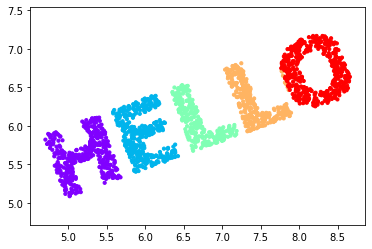

In [17]:
def rotate(X, angle):
    theta = np.deg2rad(angle) 
    R = [[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]] 
    return np.dot(X, R)



X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize, s=10) 
plt.axis('equal')

In [23]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1854, 1854)

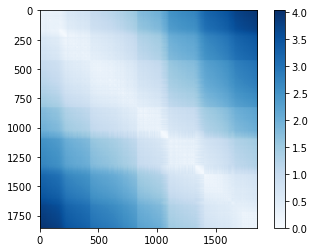

In [25]:
plt.imshow(D, cmap='Blues')
plt.colorbar()

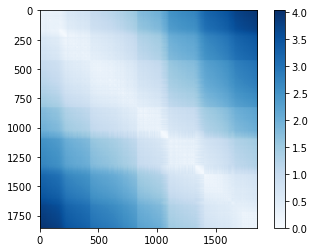

In [26]:
D2 = pairwise_distances(X2)
plt.imshow(D2, cmap='Blues')
plt.colorbar()

In [28]:
np.allclose(D,D2)

True

In [29]:
from sklearn.manifold import MDS

In [32]:
model = MDS(n_components=2, dissimilarity='precomputed')
out = model.fit_transform(D)

(-0.6341317123704917,
 0.5764835688640843,
 -2.184623481362417,
 2.246258155822187)

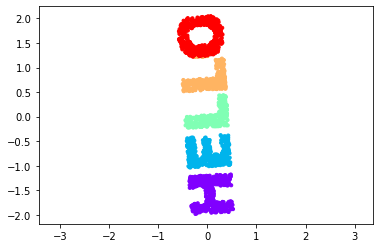

In [36]:
plt.scatter(out[:,0], out[:,1], **colorize,s=10)
plt.axis('equal')

In [37]:
def random_projection(X, dimension=3, rseed=42): 
    assert dimension >= X.shape[1] 
    rng = np.random.RandomState(rseed) 
    C = rng.randn(dimension, dimension) 
    e, V = np.linalg.eigh(np.dot(C, C.T)) 
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3) 
X3.shape

(1854, 3)

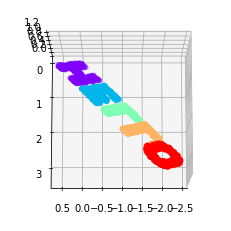

In [42]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim=90, elev=79)

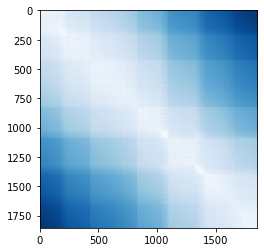

In [431]:
plt.imshow(pairwise_distances(X3), cmap='Blues')


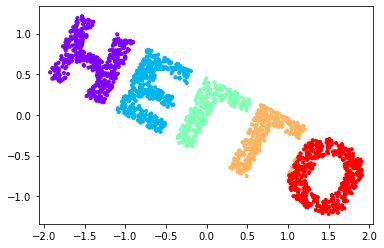

In [51]:
model = MDS(n_components=2)
out3 = model.fit_transform(X3)

plt.scatter(out3[:,0], out3[:,1], **colorize,s=10)
plt.axis('equal');

In [47]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t) 
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1) 
    return np.vstack((x, y, z)).T 
XS = make_hello_s_curve(X)

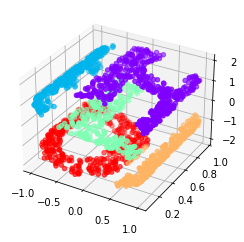

In [50]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

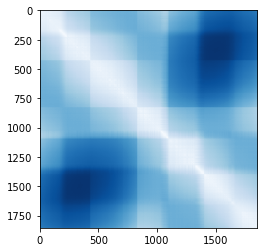

In [432]:
plt.imshow(pairwise_distances(XS), cmap='Blues')

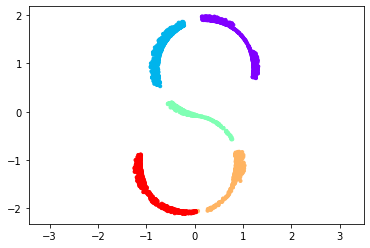

In [52]:
model = MDS(n_components=2)
out4 = model.fit_transform(XS)
plt.scatter(out4[:,0], out4[:,1], **colorize,s=10)
plt.axis('equal');

# Nonlinear Manifolds: Locally Linear Embedding

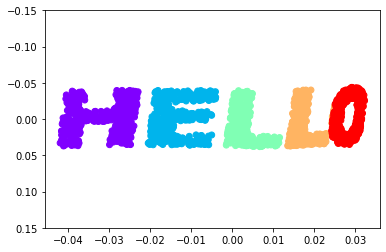

In [59]:
from sklearn.manifold import LocallyLinearEmbedding 
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',eigen_solver='dense') 
out = model.fit_transform(XS)

fig, ax = plt.subplots() 
ax.scatter(out[:, 0], out[:, 1], **colorize) 
ax.set_ylim(0.15, -0.15);

In [60]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30) 
faces.data.shape

(2370, 2914)

In [73]:
faces.images.shape

(2370, 62, 47)

In [79]:
def plot_pic(data):
    fig, axes = plt.subplots(4,8,figsize=(12,8), subplot_kw={'xticks':[],'yticks':[]}, gridspec_kw=dict(hspace=0.05, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(62,47), cmap='binary_r')
        for j in ax.spines.values():
            j.set_visible(False)

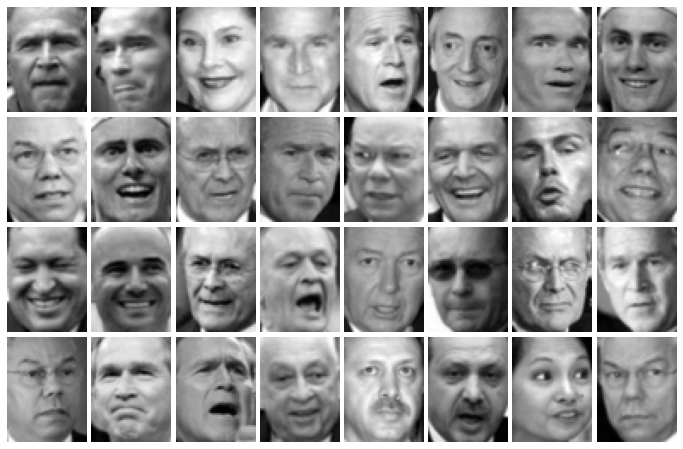

In [80]:
plot_pic(faces.data)

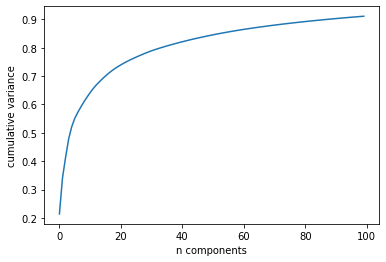

In [84]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data) 
plt.plot(np.cumsum(model.explained_variance_ratio_)) 
plt.xlabel('n components') 
plt.ylabel('cumulative variance');  # you need 100 components to get 90% of the variance

In [85]:
from sklearn.manifold import Isomap

In [86]:
modelD = Isomap(n_components = 2)

In [88]:
new_data = modelD.fit_transform(faces.data)

In [104]:
faces.target_names.shape

(34,)

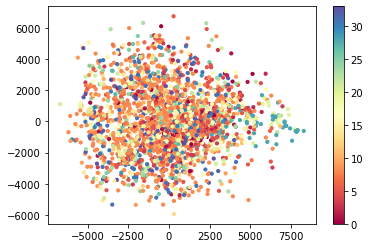

In [95]:
plt.scatter(new_data[:,0],new_data[:,1], c=faces.target, s=10, cmap='Spectral')
plt.colorbar()

In [107]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data) 
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2 
        shown_images = np.array([2 * proj.max(0)]) 
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]]) 
            imagebox = offsetbox.AnnotationBbox( offsetbox.OffsetImage(images[i], cmap=cmap), proj[i]) 
            ax.add_artist(imagebox)

# don't show points that are too close continue

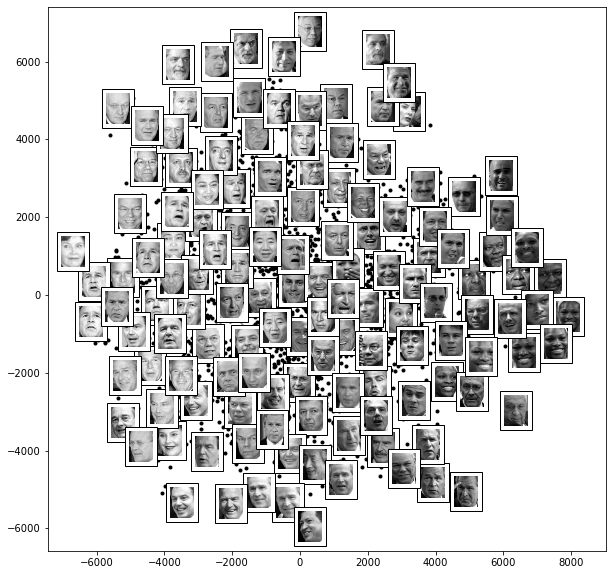

In [110]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=Isomap(n_components=2),images=faces.images[:, ::2, ::2])

In [116]:
from sklearn.datasets import fetch_openml 

In [122]:
mnist = fetch_openml('mnist_784')

In [146]:
mnist.data.shape

(70000, 784)

In [182]:
mnist.target.shape

(70000,)

In [165]:
data = mnist.data.to_numpy()

In [179]:
def plot_pic1(data):
    fig, axes = plt.subplots(6,8,figsize=(12,8), subplot_kw={'xticks':[],'yticks':[]}, gridspec_kw=dict(hspace=0.05, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[1250*i].reshape(28, 28), cmap='bone_r')
        for j in ax.spines.values():
            j.set_visible(False)

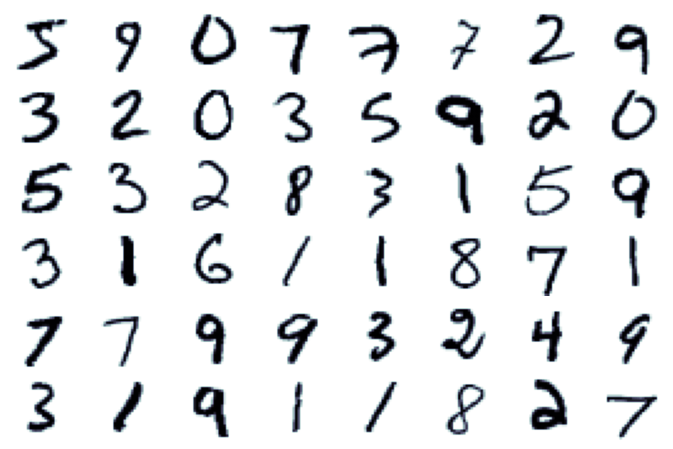

In [180]:
plot_pic1(data)

In [290]:
train = data[::30]

In [300]:
target = mnist.target[::30]

In [301]:
target.shape

(2334,)

In [303]:
list= []
for i in target:
    list.append(int(i))

In [435]:
from sklearn.decomposition import PCA

In [438]:
model = Isomap(n_components=2)
new = model.fit_transform(train)

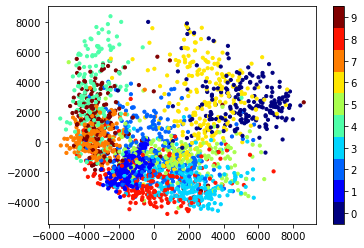

In [439]:
plt.scatter(new[:,0], new[:,1], c=list, cmap=plt.cm.get_cmap('jet', 10), s=10)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

In [440]:
model = PCA(n_components=2)
new = model.fit_transform(train)

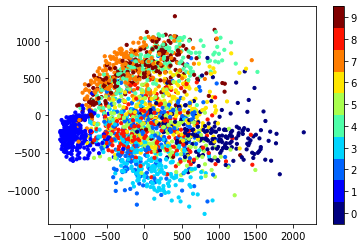

In [441]:
plt.scatter(new[:,0], new[:,1], c=list, cmap=plt.cm.get_cmap('jet', 10), s=10)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

In [455]:
model = LocallyLinearEmbedding(n_components=2)
new = model.fit_transform(train)

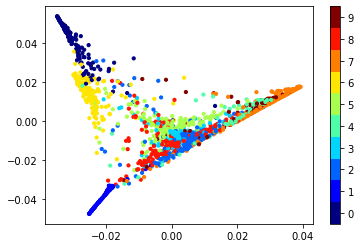

In [456]:
plt.scatter(new[:,0], new[:,1], c=list, cmap=plt.cm.get_cmap('jet', 10), s=10)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

In [405]:
mnist.data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [411]:
target = mnist.target

In [413]:
T = pd.DataFrame(target)
T

,class
0,5
1,0
2,4
3,1
4,9
...,...
69995,2
69996,3
69997,4
69998,5


In [423]:
target = T['class'].astype(int)
target == 1

0        False
1        False
2        False
3         True
4        False
         ...  
69995    False
69996    False
69997    False
69998    False
69999    False
Name: class, Length: 70000, dtype: bool

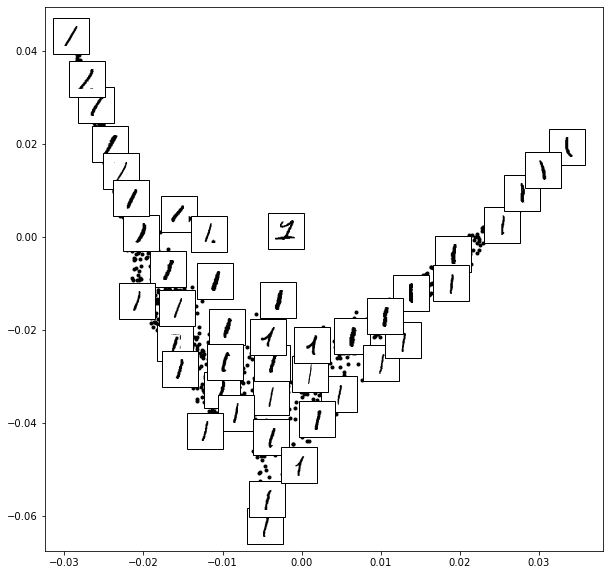

In [427]:
data = mnist.data[target == 1][::4]
data = data.to_numpy()
fig, ax = plt.subplots(figsize=(10, 10)) 
model =LocallyLinearEmbedding(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),ax=ax, thumb_frac=0.05, cmap='gray_r')

